# Hidden Factor Analysis

## Description

We provide two different procedures for hidden factor analysis from omics data in our pipeline. The first is the [Probabilistic Estimation of Expression Residuals (PEER) method](https://github.com/PMBio/peer/wiki/Tutorial), a method also used for GTEx eQTL data analysis. The second, and the one use for our main analyses, is a PCA based approach with automatic determination of the number of factors to use. This is mainly inspired by a recent benchmark from Jessica Li's group [[cf. Zhou et al., Genome Biology, 2022](https://doi.org/10.1186/s13059-022-02761-4)]. Please note that additional considerations should be taken for single-cell eQTL analysis as investigated by [[cf. Xue et al., Genome Biology, 2023](https://doi.org/10.1186/s13059-023-02873-5)].

## Input

1. Molecular phenotype in `bed.gz` file format with indexing:

In [ ]:
readr::read_delim("data/example_data.bed.gz",show_col_types= F)[1:3,1:8]

2. A covariate file in text format with the first column `#id` that lists the name of all covariates, followed by other columns each being a sample with sample names matching that in the molecular phenotype file:

In [ ]:
readr::read_delim("data/example_cov.txt",show_col_types= F)[,1:8]

Covariates file is optional to the PEER method but it should be supplied in order to construct a proper PEER model in the context of xQTL mapping.

3. For `APEX` we need an indexed VCF file to get the command to work, although this file is not used. 

### Default Parameters: Number of Factors

#### PEER

By default the pipeline applies recommendations from [GTEx](https://gtexportal.org/home/documentationPage):

> A set of covariates identified using the Probabilistic Estimation of Expression Residuals (PEER) method (Stegle et al., PLoS Comp. Biol., 2010 ), calculated for the normalized expression matrices (described below). For eQTL analyses, the number of PEER factors was determined as function of sample size (N): 15 factors for N<150, 30 factors for 150≤ N<250, 45 factors for 250≤ N<350, and 60 factors for N≥350, as a result of optimizing for the number of eGenes discovered. For sQTL analyses, 15 PEER factors were computed for each tissue.

Although one can specify fixed number of factors using `--N` option in this pipeline.

#### BiCV factor analysis with APEX

We will do the same as PEER

#### PCA with Marchenko's approach

We will use Marchenko's approach to determine the number of PC to use. 

#### PCA with Buja A and Eyuboglu N. permutation

We also provide an option to use Buja A and Eyuboglu N. to determine the number of PC to use.

## Output

### Primary Output

* `*.cov.gz`: hidden factors inferred.


### Secondary Outputs

PEER:

* Diagnosis plots for check of convergence
* peer precision /residuals /weights

## Minimal Working Example Steps
An MWE is uploaded to [google drive](https://drive.google.com/drive/folders/1yjTwoO0DYGi-J9ouMsh9fHKfDmsXJ_4I?usp=sharing).

### ii. Generate Hidden Factors

#### a. PEER Method

Because the MWE only contains 10 genes but 400+ samples. The computed N will be far greater than the number of genes. Therefore in the MWE the N is fixed to be 3.

Timing: X min

FIXME: error due to "import scipy as s" creating issue where a "s.shape" is called in [mofapy2 code](https://github.com/bioFAM/mofapy2/blame/master/mofapy2/core/distributions/basic_distributions.py)

In [4]:
!sos run covariate_hidden_factor.ipynb PEER \
   --cwd ../../../output_test/peer_factors \
   --phenoFile ../../../mwe_data/xQTL_discovery/MWE.log2cpm.mol_phe.bed.gz \
   --covFile ../../../mwe_data/xQTL_discovery/MWE.covariate.cov.gz \
   --container oras://ghcr.io/statfungen/factor_analysis_apptainer:latest \
   --N 3 \
   -c ../../csg.yml -q neurology

INFO: Running computing residual on merged covariates: 
INFO: t6daa86bd17ff21b8 re-execute completed
INFO: t6daa86bd17ff21b8 submitted to neurology with job id Your job 6008724 ("job_t6daa86bd17ff21b8") has been submitted
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: computing residual on merged covariates output:   ../../../output_test/peer_factors/MWE.log2cpm.mol_phe.MWE.covariate.cov.residual.bed.gz
INFO: Running PEER_2: 
INFO: t4b3df6fd53d8215c submitted to neurology with job id Your job 6008740 ("job_t4b3df6fd53d8215c") has been submitted
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
ERROR: [PEER_2]: [t4b3df6fd53d8215c]: Executing script in Singularity returns an error (exitcode=1, stderr=/restricted/projectnb/xqtl/xqtl_protocol/output_test/peer_factors/MWE.log2cpm.mol_phe.MWE.covariate.cov.residual.PEER_M

In [5]:
tree ./output

./output
├── MWE.Cov_PEER.PEER.cov
├── MWE.Cov_PEER.PEER.cov.stderr
├── MWE.Cov_PEER.PEER.cov.stdout
├── MWE.Cov_PEER.PEER_diagnosis.pdf
├── MWE.Cov_PEER.PEER.peer_precisions.txt
├── MWE.Cov_PEER.PEER.peer_residuals.txt
└── MWE.Cov_PEER.PEER.peer_weights.txt

0 directories, 7 files


> ./peer_output/example_data.bed_diagnosis_plot.jpeg (22.2 KiB):

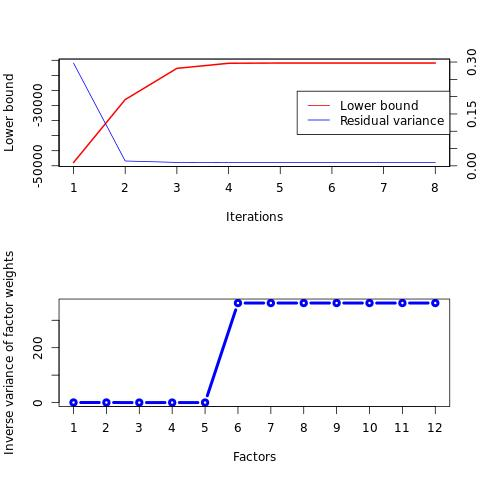

>>> ./peer_output/example_data.bed_diagnosis_plot.jpeg:

bash: ./peer_output/example_data.bed_diagnosis_plot.jpeg: Permission denied


In [3]:
%preview ./output/MWE.Cov_PEER.PEER_diagnosis.pdf -s png

In [11]:
cat ./output/MWE.Cov_PEER.PEER.cov.stdout

PEER: loading input data... PEER: loading covariate file ...done!
PEER: Input summary: 200 samples with 100 genes and 2 covariates 
Setting initialization parameters ...Done.
PEER: estimating hidden confounders (30)
	iteration 0/1000
	iteration 1/1000
	iteration 2/1000
	iteration 3/1000
	iteration 4/1000
	iteration 5/1000
Converged (var(residuals)) after 5 iterations

Exporting results ... Done.


#### b. Principal Components
This step will compute residual on merged covariates (`PC_1`) and perform hidden factor analysis  (`PC_2`)

Timing: <1 min

In [5]:
!sos run covariate_hidden_factor.ipynb PCA \
    --cwd ../../../output_test/machenko_pcs \
    --phenoFile ../../../output_test/impute/protocol_example.protein.bed.imputed.bed.gz  \
    --covFile ../../../mwe_data/protocol_data/output/covariate/protocol_example.samples.protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.gz \
    --container oras://ghcr.io/statfungen/pcatools_apptainer:latest \
    -c ../../csg.yml -q neurology



INFO: Running computing residual on merged covariates: 
INFO: t32689fab04863f6d submitted to neurology with job id Your job 6050530 ("job_t32689fab04863f6d") has been submitted
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: computing residual on merged covariates output:   ../../../output_test/machenko_pcs/protocol_example.protein.bed.imputed.protocol_example.samples.protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.residual.bed.gz
INFO: Running Marchenko_PC_2: 
INFO: t6e1a089c0a5a9fbb submitted to neurology with job id Your job 6050542 ("job_t6e1a089c0a5a9fbb") has been submitted
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Waiting for the completion of 1 task.
INFO: Marchenko_PC_2 output:   ../../../output_t

## Troubleshooting

| Step | Substep | Problem | Possible Reason | Solution |
|------|---------|---------|------------------|---------|
|  |  |  |  |  |




## Command Interface

In [2]:
!sos run covariate_hidden_factor.ipynb -h

usage: sos run covariate_hidden_factor.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  Marchenko_PC
  PEER
  BiCV

Global Workflow Options:
  --cwd output (as path)
                        The output directory for generated files. MUST BE FULL
                        PATH
  --covFile VAL (as path, required)
                        Merged Covariates File
  --phenoFile VAL (as path, required)
                        Path to the input molecular phenotype data.
  --name  f'{phenoFile:bnn}.{covFile:bn}'

  --job-size 1 (as int)
                        For cluster jobs, number commands to run per job
  --walltime 5h
                        Wall clock time expected
  --m

## Setup and global parameters

In [2]:
[global]
# The output directory for generated files. MUST BE FULL PATH
parameter: cwd = path("output")
# Merged Covariates File
parameter: covFile = path
# Path to the input molecular phenotype data.
parameter: phenoFile = path
parameter: name = f'{phenoFile:bnn}.{covFile:bn}'
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 8
# Software container option
parameter: container = ""
parameter: entrypoint= ""

In [3]:
[*_1(computing residual on merged covariates)]
parameter: mean_impute_missing = False
input: phenoFile, covFile
output: f'{cwd}/{name}.residual.bed.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime,  mem = mem, tags = f'{step_name}_{_output:bn}'
R: expand = "${ }", stderr = f'{_output:nn}.stderr', stdout = f'{_output:nn}.stdout' , container = container, entrypoint = entrypoint

    mean_impute <- function(d){
      f <- apply(d, 2, function(x) mean(x, na.rm = TRUE))
      for (i in 1:length(f)) d[,i][which(is.na(d[,i]))] <- f[i]
      return(d)
    }
  
    library(dplyr)
    library(readr)
    pheno = read_delim(${_input[0]:r},delim = "\t")
    covariate= read_delim(${_input[1]:r},delim = "\t") 

    # Extract samples in both files (Outliers will be removed in here as they are no longer presented in the header of factor)
    extraction_sample_list <- intersect(colnames(pheno), colnames(covariate)) 
    
    
    if(length(extraction_sample_list) == 0){
      stop("No samples are overlapped in two files!")
    }
    
    ## Report sample counts:
    print(paste((ncol(pheno) - 4), "samples are in the phenotype file", sep = " "))
    print(paste((ncol(covariate) - 1), "samples are in the covariate file", sep = " "))

    ## Report identical samples:
    print(paste(length(extraction_sample_list), "samples overlap between phenotype & covariate files and are included in the analysis:", sep = " "))
    print(extraction_sample_list)

    ## Report non-overlapping samples :
    covariate_missing = covariate %>% select(-all_of('#id')) %>% select(-all_of(extraction_sample_list))
    print(paste(ncol(covariate_missing), "samples in the covariate file are missing from the phenotype file:", sep = " "))
    print(colnames(covariate_missing))

    pheno_missing = pheno %>% select(-c(1:4)) %>% select(-all_of(extraction_sample_list))
    print(paste(ncol(pheno_missing), "samples in the phenotype file are missing from the covariate file:", sep = " "))
    print(colnames(pheno_missing))

    # Subset the data:
    covariate = covariate[,extraction_sample_list]%>%as.matrix()%>%t()
    pheno_id = pheno%>%select(1:4)
    pheno = pheno%>%select(all_of(rownames(covariate)))%>%as.matrix()%>%t()
    if (${"T" if mean_impute_missing else "F"}) {
      pheno = mean_impute(pheno)
    } else {
      if(sum(is.na(pheno)) > 0){ stop("NA in phenotype input is not allowed!") }
    }
    # Get residual 
    pheno_resid = .lm.fit(x = cbind(1,covariate), y = pheno)$residuals
    pheno_output = cbind(pheno_id, pheno_resid%>%t())
    pheno_output%>%write_delim("${_output:n}",delim = "\t")
  
bash: expand = "${ }", stderr = f'{_output:nn}.stderr', stdout = f'{_output:nn}.stdout', container = container, entrypoint = entrypoint
    bgzip -f ${_output:n}
    tabix -p bed ${_output}

    stdout=${_output:n}.stdout 
    for i in ${_output} ; do 
    echo "output_info: $i " >> $stdout;
    echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
    echo "output_rows:" `zcat $i | wc -l  | cut -f 1 -d " "`   >> $stdout;
    echo "output_column:" `zcat $i | head -1 | wc -w `   >> $stdout;
    echo "output_preview:"   >> $stdout;
    zcat $i | head  | cut -f 1,2,3,4,5,6   >> $stdout ; done

### Principal Components Analysis on molecular phenotype matrix

In [4]:
[Marchenko_PC_2, PCA_2]
# Marchenko or Buja_Eyuboglu
parameter: choose_k_method = "Marchenko"
output: f'{cwd}/{_input:bnnn}.{choose_k_method}_PC.gz'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', entrypoint = entrypoint
    library("dplyr")
    library("readr")
    library("PCAtools")
    library('BiocSingular')
    residExpPath  = "${_input}"
    covPath = "${covFile}"
    residExpDF <- read_delim(residExpPath, show_col_types=FALSE)
    covDF <- read_delim(covPath, show_col_types=FALSE)
    commonMPSamples <- intersect(colnames(covDF), colnames(residExpDF))
    covDFcommon <- cbind(covDF[, 1], covDF[, commonMPSamples])
  
    residExpPC <- pca(
        residExpDF[,commonMPSamples], # The first four columns are: chr, start, end, and gene_id; so we skip those.
        scale = TRUE,
        center = TRUE,
        BSPARAM = ExactParam())

    # Choose the number of PC
    MPPCNum <- 0
    if (${"T" if choose_k_method == "Marchenko" else "F"}) {
        M <- apply(residExpDF[, commonMPSamples], 1, function(X){ (X - mean(X))/sqrt(var(X))});
        residSigma2 <- var(as.vector(M));
        paste('sigma2:', residSigma2)
        MPPCNum <- chooseMarchenkoPastur(
        .dim = dim(residExpDF[, commonMPSamples]), var.explained=residExpPC$sdev^2, noise=residSigma2)
    }
    if (${"T" if choose_k_method == "Buja_Eyuboglu" else "F"}) {
        MPPCNum <- jackstraw::permutationPA(data.matrix(residExpDF[, commonMPSamples]), B = 100, threshold = 0.05, verbose = F)$r
    }
    if (MPPCNum == 0) stop("Invalid choice of methods to choose K for PCA: ${choose_k_method}")

    MPPCsDF <- as.data.frame(residExpPC$rotated[, 1:MPPCNum])
    MPColMatrix <-  matrix(c(rep('Hidden_Factor_PC', times=MPPCNum), seq(1, MPPCNum)), ncol=2, nrow=MPPCNum)
    colnames(MPPCsDF) <- apply(MPColMatrix, 1, function(X){return(paste0(X[1], X[2]))})
    # Add #id Column
    MPPCsDF <- as.data.frame(t(MPPCsDF))
    MPPCsDF$id <- rownames(MPPCsDF)
    MPPCsDF <- MPPCsDF %>% select(id, everything()) %>% rename("#id" = "id")
    write_delim((rbind(covDFcommon, MPPCsDF)), "${_output}", "\t")

bash: expand= "$[ ]", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint = entrypoint
        stdout=$[_output:n].stdout
        for i in $[_output] ; do 
        echo "output_info $i " >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        echo "output_rows:" `zcat $i | wc -l  | cut -f 1 -d " "`   >> $stdout;
        echo "output_column:" `zcat $i | head -1 | wc -w `   >> $stdout;
        echo "output_preview:"   >> $stdout;
        zcat $i | head  | cut -f 1,2,3,4,5,6   >> $stdout ; done

### PEER Method

In [ ]:
[PEER_2]
# N PEER factors, If do not specify or specified as 0, default values suggested by 
# GTEx (based on different sample size) will be used
parameter: N = 0
# Default values from PEER software:
## The number of max iteration
parameter: iteration = 1000
### Prior parameters
#parameter: Alpha_a = 0.001
#parameter: Alpha_b = 0.1
#parameter: Eps_a = 0.1
#parameter: Eps_b = 10.0
# Tolarance parameters
parameter: tol = 0.001
#parameter: var_tol = 0.00001
# minimum variance explained criteria to drop factors while training
parameter: r2_tol = False
# Convergence mode: Convergence mode for MOFAr "slow", "medium" or "fast", corresponding to 1e-5%, 1e-4% or 1e-3% deltaELBO change.
parameter: convergence_mode = "fast"
# input is the residual file from the first step
output: f'{cwd:a}/{_input:bnn}.PEER_MODEL.hd5'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
python: container=container, expand= "${ }", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', entrypoint = entrypoint
    from mofapy2.run.entry_point import entry_point
    import pandas as pd
    import os
    ## Force the number of threads used in numpy.
    os.environ["OMP_NUM_THREADS"] = "${numThreads}" # export OMP_NUM_THREADS=4
    os.environ["OPENBLAS_NUM_THREADS"] = "${numThreads}" # export OPENBLAS_NUM_THREADS=4 
    os.environ["MKL_NUM_THREADS"] = "${numThreads}" # export MKL_NUM_THREADS=6
    import numpy as np
    ## Data
    data = pd.read_csv(${_input:r},"\t",index_col = 3).drop(["#chr","start","end"],axis = 1)
    # initialise the entry point
    ent = entry_point()
    # Guess number of factor
    # Suggest the number of factors to use if no input value
    num_factor = ${N}
    if num_factor == 0:
        if len(data.columns) < 150:
            num_factor = 15
        elif len(data.columns) < 250:
            num_factor = 30
        elif len(data.columns) < 350:
            num_factor = 45
        else:
            num_factor = 60
    # Set data
    # MOFA is a multi-view and multi-group inference framework. 
    # If usig only a single view and a single group (as in PEER), the data needs to be embedded into a nested list
    ent.set_data_matrix([[data.transpose()]],samples_names=[data.columns.values.tolist()], features_names=[data.index.values.tolist()])
    ent.set_model_options(factors= num_factor , spikeslab_weights=False, ard_weights=False)
    ent.set_train_options(iter=${iteration}, convergence_mode="${convergence_mode}" ${f',dropR2 = {r2_tol}' if r2_tol else "" }, startELBO=1, freqELBO=1,tolerance=${tol}, gpu_mode=False, verbose=True, seed=42)
    ent.build()
    ent.run()
    ent.save(${_output:ar})
    ## To fix issue https://github.com/statfungen/xqtl-protocol/issues/420
    import h5py
    right_name = [x.encode("UTF-8") for x in  ent.data_opts["features_names"][0]] 
    new_hd5 = h5py.File(${_output:ar}, "r+")
    del new_hd5["features/view0"]
    new_hd5["features"].create_dataset("view0", data=np.array(right_name))
    new_hd5.close()

In [ ]:
[PEER_3]
output: f'{cwd:a}/{_input:bnn}.PEER.gz', f'{cwd:a}/{_input:bnn}.PEER.diag.pdf'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R:  container=container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', entrypoint = entrypoint
    ####################
    ## Load libraries ##
    ####################
    
    library(MOFA2)
    library(dplyr)
    library(readr)
    ################
    ## Load model ##
    ################
    
    file <- "${_input}"
    model <- load_model(file)
    
    ####################################
    ## (Optional) add sample metadata ##
    ####################################
    
    # Important: 
    # (1) the row names in the sample metadata data.frame have to match the sample names in the MOFA model
    # (2) the sample name has to contain at least two columns: 
    # 		- sample: sample names
    #		- group: group name. Only required for multi-group inference. In your case just set the entire column to the same value
    
    # Load metadata
    
    # stopifnot(all(samples(model)[[1]]==metadata$sample))
    # samples_metadata(model) <- metadata
    
    ###############################
    ## (Optional) Subset factors ##
    ###############################
    
    # We can remove factors that explain little variance (in this case, we require at least 0.01%)
    # r2 <- model@cache$variance_explained$r2_per_factor
    # factors <- sapply(r2, function(x) x[,1]>0.0001)
    # model <- subset_factors(model, which(apply(factors,1,sum) >= 1))
    
    # fetch factors in matrix format, with dimensions (nfactors,nsamples)
    factors <- get_factors(model)[[1]]
    dim(factors)
    factors = as_tibble(t(factors),rownames = "#id")
    covPath = "${covFile}"
    options(readr.show_col_types = FALSE)
    covDF <- read_delim(covPath, delim = '\t')
    commonMPSamples <- intersect(colnames(covDF), colnames(factors))      
    (rbind(covDF[, commonMPSamples], factors[, commonMPSamples])%>%write_delim("${_output[0]}","\t"))
    # Plot save to vcf
    pdf("${_output[1]}")
    #############################
    ## Plot variance explained ##
    #############################
    
    # Plot variance explained using individual factors
    plot_variance_explained(model, factors="all")
    plot_variance_explained(model, factors=c(1,2,3))
    
    # Plot total variance explained using all factors
    plot_variance_explained(model, plot_total = TRUE)[[2]]
    
    ########################
    ## Plot factor values ##
    ########################
    
    plot_factor(model, factor = 1)
    plot_factors(model, factor = c(1,2))
    
    ###########################
    ## Plot feature loadings ##
    ###########################
    
    # The weights or loadings provide a score for each gene on each factor. 
    # Genes with no association with the factor are expected to have values close to zero
    # Genes with strong association with the factor are expected to have large absolute values. 
    # The sign of the loading indicates the direction of the effect: a positive loading indicates that the feature is more active in the cells with positive factor values, and viceversa.
    
    # Plot the distribution of loadings for Factor 1.
    plot_weights(model,
      view = 1,
      factor = 1,
      nfeatures = 10,     # Top number of features to highlight
      scale = T           # Scale loadings from -1 to 1
    )
    
    # If you are not interested in the full distribution, but just on the top loadings:
    plot_top_weights(model, 
      view = 1, 
      factor = 1, 
      nfeatures = 10,
      scale = T
    )
    
    ######################################
    ## Plot correlation between factors ##
    ######################################
    
    plot_factor_cor(model)
    
    ###################
    ## Fetch factors ##
    ###################
    invisible(dev.off())
bash: expand= "$[ ]", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', container = container, entrypoint = entrypoint
        for i in $[_output[0]] ; do 
        echo "output_info $i " >> $[_output[0]:n].stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $[_output[0]:n].stdout;
        echo "output_rows:" `zcat $i | wc -l  | cut -f 1 -d " "`   >> $[_output[0]:n].stdout;
        echo "output_column:" `zcat $i | head -1 | wc -w `   >> $[_output[0]:n].stdout;
        echo "output_preview:"   >> $[_output[0]:n].stdout;
        zcat $i | head  | cut -f 1,2,3,4,5,6   >> $[_output[0]:n].stdout ; done

#### Reference
* PEER code is adapted from [here](https://github.com/RTIInternational/biocloud_docker_tools/blob/master/peer/v1.3/run_peer.R)
* GTEx recommandation of PEER factors is [here](https://gtexportal.org/home/documentationPage)
* Examples by PEER is at [github](https://github.com/PMBio/peer/wiki/Tutorial)

### BiCV Factor Analysis with APEX

Factor anallysis using Bi-Cross validation with the APEX software package [[cf. Owen et al., Statistical Science, 2016](https://doi.org/10.1214/15-STS539)] [[cf. Quick et al., bioRxiv, 2020](https://doi.org/10.1101/2020.12.18.423490)]

Notice that the command options are different from those on the APEX website documentation. The commands on the documentation page does not work (last updated September 2021). The commands below were constructed and tested by our team based on our understanding of the program, without input from APEX authors.


In [ ]:
[BiCV_2]
# For cluster jobs, number commands to run per job
import time
output: f'{cwd:a}/{_input:bn}.fake.vcf.gz'
#task: trunk_workers = 1,trunk_size = job_size , walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
R: container=container, expand= "$[ ]", stderr = f'{_output}.stderr', stdout = f'{_output}.stdout', entrypoint = entrypoint
    library("dplyr")
    library("readr")
    ## Add fake header
    cat(paste("##fileformat=VCFv4.2\n##fileDate=$[time.strftime("%Y%m%d",time.localtime())]\n##source=FAKE\n"), file=$[_output:nr], append=FALSE)
    ## Add colnames based on bed
    pheno = read_delim("$[_input]", delim = "\t",n_max = 1)
    colnames(pheno)[1:3] = c("#CHROM","POS","ID") 
    pheno = cbind(pheno[1:3]%>%mutate(REF = "A", ALT = "C", QUAL = ".",FILTER = ".", INFO = "PR", FORMAT = "GT"),pheno[,5:ncol(pheno)])
    pheno%>%write_delim($[_output:nr],delim = "\t",col_names = T, append = T)
bash: container=container, expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', entrypoint = entrypoint
    bgzip -f $[_output:n]
    tabix -p vcf $[_output]

In [ ]:
[BiCV_3]
# N factors, if not specify, calculated based on sample size according to GTeX
parameter: N = 0
# The number of iteration
parameter: iteration = 10

import pandas as pd
data = pd.read_csv(phenoFile,"\t",index_col = 3).drop(["#chr","start","end"],axis = 1)
if N == 0:
    if len(data.columns) < 150:
        N = 15
    elif len(data.columns) < 250:
        N = 30
    elif len(data.columns) < 350:
        N = 45
    else:
        N = 60
input: output_from(1), output_from(2)
output: f'{cwd:a}/{_input[0]:bnn}.BiCV.gz'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: container=container, expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', entrypoint = entrypoint
    apex factor \
        --out $[_output[0]:nn] \
        --iter $[iteration] \
        --factors $[N] \
        --bed $[_input[0]] \
        --vcf $[_input[1]] \
        --threads $[numThreads]  $[ f'--cov {covFile}' if covFile.is_file() else '']